In [119]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd

# Graph Managment
import graph_tool.all as gt
import networkx as nx

from matplotlib.patches import ArrowStyle
from matplotlib.patches import Ellipse
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image as IPImage

from glob import glob
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

In [95]:
# Prerequistes, are usually constant could change 
pos_label = {
    0: (-2.5,-0.3),
    1: (2.5,-0.3),
    2: (0,2.5),
    3: (0,-2.5)
}
pos = {
    0: (-2,0),
    1: (2,0),
    2: (0,2),
    3: (0,-2)
}
color_map_dict = {
    'Sin Clasificar': 'purple',
    'Izquierda': 'darkblue',
    'Derecha': 'red',
    'Centro': 'forestgreen'
}

def normalized(x, max, min):
    return ((x - min)/(max - min))

In [3]:
# This will get the metrics that will be plotted
def get_minimal_graph(file):
    g = gt.load_graph(file)
    date = g.gp['Date']
    
    node_list = [
        (0,{'Political Label': 'Izquierda'}),
        (1,{'Political Label': 'Derecha'}),
        (2,{'Political Label': 'Centro'}),
        (3,{'Political Label': 'Sin Clasificar'}) 
    ]
    
    node_dict = {property['Political Label']: node for node, property in node_list}

    edge_list = []
    for x in node_list:
        s = x[0]
        x[1]['Og Tweets'] = 0
        for d in node_list:
            t = d[0]
            edge_list.append((s,t, {'Sum Weights': 0}))
    
    for e in edge_list:
        source = e[0]
        target = e[1]
        s_pa = node_list[source][1]['Political Label']
        t_pa = node_list[target][1]['Political Label']
        
        for g_e in g.edges():
            if g.vp['Political Label'][g_e.source()] == s_pa and g.vp['Political Label'][g_e.target()] == t_pa:
                e[2]['Sum Weights'] += g.ep['Normal Weight'][g_e]
    
    for v in g.vertices():
        node = node_dict[g.vp['Political Label'][v]]
        node_list[node][1]['Og Tweets'] += g.vp['Tweets'][v]
    
    G = nx.DiGraph()
    G.add_nodes_from(node_list)
    G.add_edges_from(edge_list)
    
    return G, date

In [4]:
# Example
G,d = get_minimal_graph('/mnt/disk2/Data/Daily_graphs/Graphs/starting_2021-05-03.graphml')

In [98]:
#Plots Size of nodes according to original Tweets
def plot_minimal_no_self_loops(G, date, ax):

    # Node Color
    nodes_colors = [color_map_dict[G.nodes[node]['Political Label']] for node in G.nodes]
    # Node Label
    node_labels = nx.get_node_attributes(G, 'Political Label')

    # Node Weight (Weight of the self loops)
    node_weight = [d['Sum Weights'] for s,t,d in G.edges(data=True) if s==t]
    max_s = max(node_weight)
    min_s = min(node_weight)
    node_weights_normalized = list(map(lambda x: normalized(x, max_s, min_s), node_weight))

    # Node Size
    node_sizes = list(map(lambda x: 300*x, node_weights_normalized))
    nx.draw_networkx_nodes(G, pos,ax = ax,
                        node_color=nodes_colors,
                        node_size=node_sizes,
                        alpha = 0.7)

    # Edges No Self Loop
    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges() and edge[0]!=edge[1]]
    # Edge Color
    color_curved = [color_map_dict[G.nodes(data=True)[edge[0]]['Political Label']] for edge in curved_edges]

    # Edge Weights (Used for calculating alpha and width)
    curved_weights_list = [edge[2]['Sum Weights'] for edge in G.edges(data=True) if edge[0:2] in curved_edges]
    max_w = max(curved_weights_list)
    min_w = min(curved_weights_list)
    curved_weights_normalized = list(map(lambda x: normalized(x, max_w, min_w), curved_weights_list))

    # Edge Size
    curved_width = list(map(lambda x: 4*x, curved_weights_normalized))

    # Radious of Edges
    arc_rad = 0.2
    nx.draw_networkx_edges(G, pos, ax=ax,
                        edgelist=curved_edges,
                        width = curved_width,
                        edge_color = color_curved,
                        alpha = curved_weights_normalized,
                        arrowstyle=ArrowStyle.Fancy(head_length=0.8, head_width=0.8),
                        connectionstyle=f'arc3, rad = {arc_rad}')
    nx.draw_networkx_labels(G, pos_label, node_labels, ax=ax,
                            font_size = 10,
                            font_family = 'cmr10')
    
    ax.set_xlim(-3, 3)  # Adjust limits to ensure self-loops are within figure bounds
    ax.set_ylim(-3, 3)
    ax.set_title(f'Twitter Network from {date}',fontfamily = 'cmr10')

In [126]:
# Plots Nodes Sizes as the sum of the Weight of a group to itself
def plot_minimal_tweets(G, date, ax):
    pos_label_ = pos_label.copy()
    #pos_label_[2] = (0,3)
    #pos_label_[3] = (0,-2.45)

    # Node Color
    nodes_colors = [color_map_dict[G.nodes[node]['Political Label']] for node in G.nodes]
    # Node Label
    node_labels = nx.get_node_attributes(G, 'Political Label')

    # Node Weight (Weight of the self loops)
    node_weight = nx.get_node_attributes(G, 'Og Tweets').values()
    max_s = max(node_weight)
    min_s = min(node_weight)
    node_weights_normalized = list(map(lambda x: normalized(x, max_s, min_s), node_weight))

    # Node Size
    node_sizes = list(map(lambda x: 300*x, node_weights_normalized))
    nx.draw_networkx_nodes(G, pos,ax = ax,
                        node_color=nodes_colors,
                        node_size=node_sizes,
                        alpha = 0.7)

    # Edges No Self Loop
    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges() if edge[0] != edge[1]]
    self_edges = [edge for edge in G.edges() if edge[0] == edge[1]]
    
    # Edge Color
    color_curved = [color_map_dict[G.nodes(data=True)[edge[0]]['Political Label']] for edge in curved_edges]
    color_self = [color_map_dict[G.nodes(data=True)[edge[0]]['Political Label']] for edge in self_edges]

    # Edge Weights (Used for calculating alpha and width)
    curved_weights_list = [edge[2]['Sum Weights'] for edge in G.edges(data=True) if edge[0:2] in curved_edges]
    self_weights_dict = {edge[0]: edge[2]['Sum Weights'] for edge in G.edges(data=True) if edge[0:2] in self_edges}
    
    max_w = max(max(curved_weights_list),max(self_weights_dict.values()))
    min_w = min(min(curved_weights_list),min(self_weights_dict.values()))
    curved_weights_normalized = list(map(lambda x: normalized(x, max_w, min_w), curved_weights_list))
    self_weights_alpha = {key: normalized(value, max_w, min_w) for key,value in self_weights_dict.items()}
    self_weights_width = {key: 4*normalized(value, max_w, min_w) for key,value in self_weights_dict.items()}

    # Edge Size
    curved_width = list(map(lambda x: 4*x, curved_weights_normalized))

    # Radious of Edges
    arc_rad = 0.2
    nx.draw_networkx_edges(G, pos, ax=ax,
                        edgelist=curved_edges,
                        width = curved_width,
                        edge_color = color_curved,
                        alpha = curved_weights_normalized,
                        arrowstyle=ArrowStyle.Fancy(head_length=0.8, head_width=0.8),
                        connectionstyle=f'arc3, rad = {arc_rad}')
    
    for node, (x, y) in pos.items():
        if G.has_edge(node, node):
            ellipse = Ellipse((x, y+0.4), width=0.4, height=0.8, angle=0, color=color_map_dict[G.nodes[node]['Political Label']], fill=False,
                            linewidth=self_weights_width[node], alpha=self_weights_alpha[node])
            plt.gca().add_artist(ellipse)
    nx.draw_networkx_labels(G, pos_label_, node_labels, ax=ax,
                            font_size = 10,
                            font_family = 'cmr10')
    
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)
    ax.set_title(f'Twitter Network from {date}',fontfamily = 'cmr10')

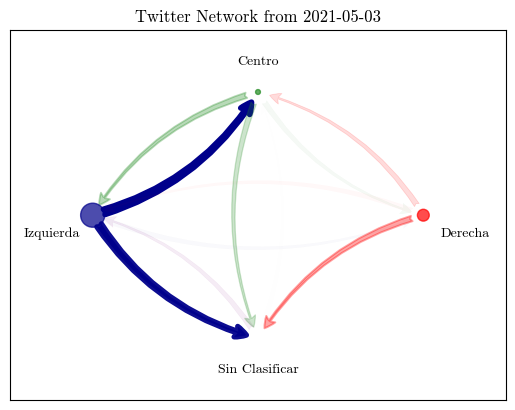

In [102]:
fig, ax = plt.subplots()
plot_minimal_no_self_loops(G,d,ax)

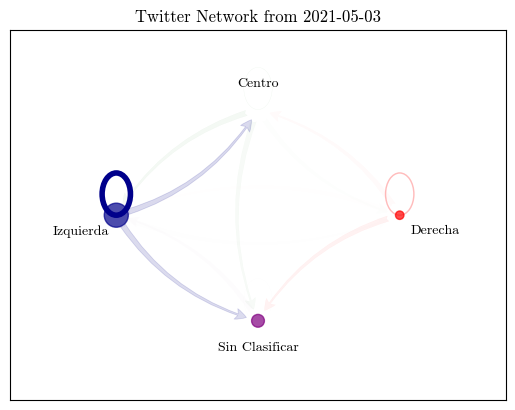

In [127]:
fig, ax = plt.subplots()
plot_minimal_tweets(G,d,ax)

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
def save_to_pil(file):
    fig, ax = plt.subplots()
    G,d = get_minimal_graph(file)
    plot_minimal_tweets(G,d,ax)
    plt.close(fig)
    
    # Save the matplotlib figure to a PIL Image object
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg')
    buf.seek(0)
    img_tweet = Image.open(buf)
    
    fig, ax = plt.subplots()
    G,d = get_minimal_graph(file)
    plot_minimal_no_self_loops(G,d,ax)
    plt.close(fig)
    
    # Save the matplotlib figure to a PIL Image object
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg')
    buf.seek(0)
    img_no_self_loop = Image.open(buf)
    
    return d, img_tweet, img_no_self_loop

def main(files):
    with ProcessPoolExecutor() as executor:
        images = list(tqdm(executor.map(save_to_pil, files), total=len(files)))
    return images

if __name__=='__main__':
    files = sorted(glob('/mnt/disk2/Data/Daily_graphs/Graphs/*.graphml'))
    images = main(files)
    imgs_tweets = [x[1] for x in sorted(images, key=lambda x: x[0])]
    imgs_no_self_loop = [x[2] for x in sorted(images, key=lambda x: x[0])]
    
    imgs_tweets[0].save('../Results/Daily_graphs_Viz/minimal_graph.gif',
                        save_all=True, append_images=imgs_tweets[1:], optimize=False, duration=250, loop=0)
    imgs_no_self_loop[0].save('../Results/Daily_graphs_Viz/minimal_graph_no_self_loop.gif',
                              save_all=True, append_images=imgs_no_self_loop[1:], optimize=False, duration=250, loop=0)

100%|██████████| 63/63 [01:00<00:00,  1.05it/s]
